In [2]:
# run command:$ jupyter nbconvert --to notebook --inplace --execute main.ipynb

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import GridSearch
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import os

/Users/george/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/p6/5001066s77n46skkbgghlkx00000gn/T/ipykernel_63213/2061037263.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import GridSearch


In [3]:
# define the scaler
scaler = MinMaxScaler()

# label encoder
label_encoder = LabelEncoder()

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Normalize the data
images_normalized = scaler.fit_transform(images)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# Print the shape of the dataset
print("(Number of images, Shape of images):", images.shape)
print("(Number of labels):", labels.shape)

(Number of images, Shape of images): (70000, 784)
(Number of labels): (70000,)


In [83]:
# Perform PCA
features = 78
pca = PCA(n_components=features)  # Reduce the dimensionality to 2 for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# Get the most relevant features (pixels) for the first principal component
most_relevant_features = np.argsort(pca.components_[0])[-features:][::-1]

# Compute the reconstruction error
X_train_reconstructed = pca.inverse_transform(X_train_pca)
reconstruction_error = np.mean(np.square(X_train - X_train_reconstructed))

# Print the reconstruction error
print("Reconstruction Error:", reconstruction_error)


Reconstruction Error: 0.1293717009181705


In [104]:
# Perform Isolation Forest
isolation_forest = IsolationForest()
isolation_forest.fit(X_train)

# Predict outliers
outliers_train = isolation_forest.predict(X_train)
outliers_test = isolation_forest.predict(X_test)

# Print the number of outliers detected
print("Number of outliers in training data:", np.sum(outliers_train == -1))
print("Number of outliers in test data:", np.sum(outliers_test == -1))

Number of outliers in training data: 11134
Number of outliers in test data: 1296


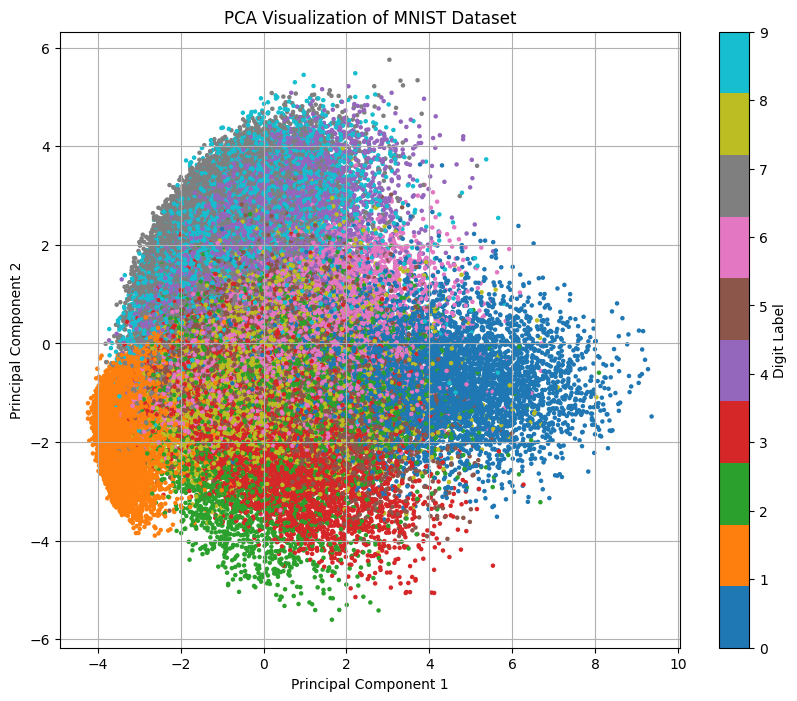

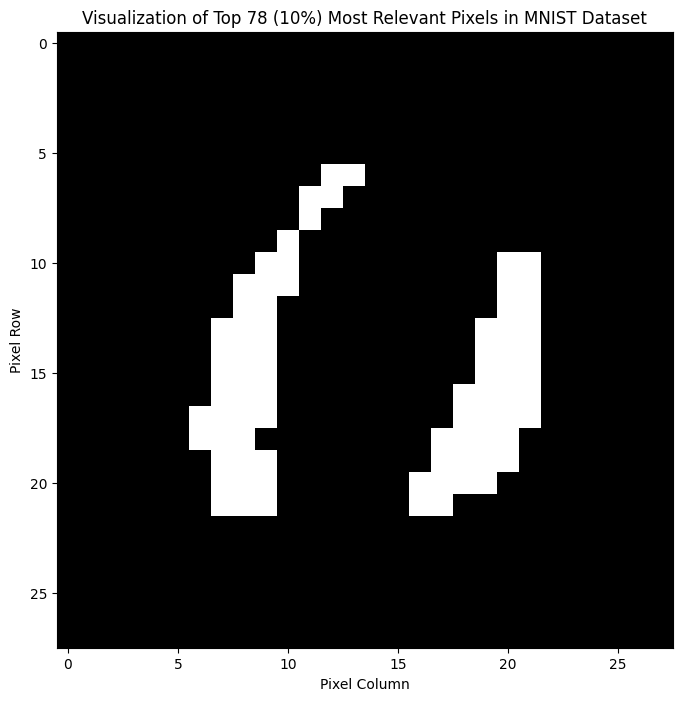

In [84]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.astype(int), cmap='tab10', s=5)
plt.colorbar(label='Digit Label')
plt.title('PCA Visualization of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.grid(True)
plt.show()

# Create a 28x28 grid
grid = np.zeros((28, 28))

# Set the value of the top 10 most relevant pixels to 1
top_pixels = np.argsort(pca.components_[0])[-features:]
for pixel_idx in top_pixels:
    row_idx = pixel_idx // 28
    col_idx = pixel_idx % 28
    grid[row_idx, col_idx] = 1

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.title('Visualization of Top 78 (10%) Most Relevant Pixels in MNIST Dataset')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.grid(False)
plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define the parameter grid
param_grid = {'n_neighbors': np.arange(int(np.sqrt(7000)), int(np.sqrt(7000) + 100))}

# Create KNN classifier
clf_knn = KNeighborsClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(clf_knn, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameter value
best_k = grid_search.best_params_['n_neighbors']

# Train the model with the best parameter
clf_knn_best = KNeighborsClassifier(n_neighbors=best_k)
clf_knn_best.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_knn_best.score(X_test, y_test)
print("Accuracy of KNN classifier with best k:", accuracy)


Accuracy of KNN classifier with best k: 0.9442857142857143


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.1, 1], 'gamma': ['scale', 'auto']}

# Create SVM classifier
svm_classifier = SVC(kernel='rbf')

# Create GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameter values
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Train the model with the best parameters
svm_classifier_best = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_classifier_best.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier_best.score(X_test, y_test)
print("Accuracy of SVM classifier with best parameters:", accuracy)


Accuracy of SVM classifier with best parameters: 0.9832857142857143


In [93]:
# GBT takes a really long time to run
# Define the Gradient Boosting model
clf_gbt = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    verbose=0,
)

# train the model
clf_gbt.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_gbt.score(X_test, y_test)
print("Accuracy of GBT classifier:", accuracy)

Accuracy of GBT classifier: 0.8465714285714285


In [88]:
# define the Convolutional Neural Network

tensorboard_callback = TensorBoard(log_dir="./logs")

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_reshaped, y_train_encoded, epochs=5, callbacks=[tensorboard_callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped,  y_test_encoded, verbose=0)
print("Accuracy of CNN classifier:", test_acc)


Epoch 1/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8948 - loss: 0.3355
Epoch 2/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9856 - loss: 0.0439
Epoch 3/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9899 - loss: 0.0327
Epoch 4/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9913 - loss: 0.0262
Epoch 5/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9947 - loss: 0.0177
Accuracy of CNN classifier: 0.9901428818702698


In [116]:
# Parameter tunning
# Define the model building function
def build_model(hp):
    model = keras.Sequential()
    # Convolutional layers apply a set of learnable filters to input data.
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    # Max pooling layers downsample the input along the spatial dimensions 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    #  Flattens the input tensor into a 1-dimensional tensor.
    model.add(layers.Flatten())
    # perform a linear transformation followed by an activation function.
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(10))

    model.compile(optimizer='adam',do
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Instantiate label encoder
label_encoder = LabelEncoder()

# Convert labels to integer format for CNN
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# Instantiate the tuner
tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='grid_search',
    project_name='mnist_cnn_grid_search'
)

# Perform the hyperparameter search
tuner.search(X_train_reshaped, y_train_encoded, epochs=5, validation_data=(X_test_reshaped, y_test_encoded))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_reshaped, y_train_encoded, epochs=5, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test_reshaped, y_test_encoded)
print("Accuracy of the best model:", test_acc)


Reloading Tuner from grid_search/mnist_cnn_grid_search/tuner0.json
Epoch 1/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9016 - loss: 0.3084 - val_accuracy: 0.9844 - val_loss: 0.0518
Epoch 2/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9858 - loss: 0.0476 - val_accuracy: 0.9871 - val_loss: 0.0432
Epoch 3/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9893 - loss: 0.0335 - val_accuracy: 0.9904 - val_loss: 0.0315
Epoch 4/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9931 - loss: 0.0225 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 5/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9903 - val_loss: 0.0272
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0213
Accuracy of the best model: 0.9902856945991516


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


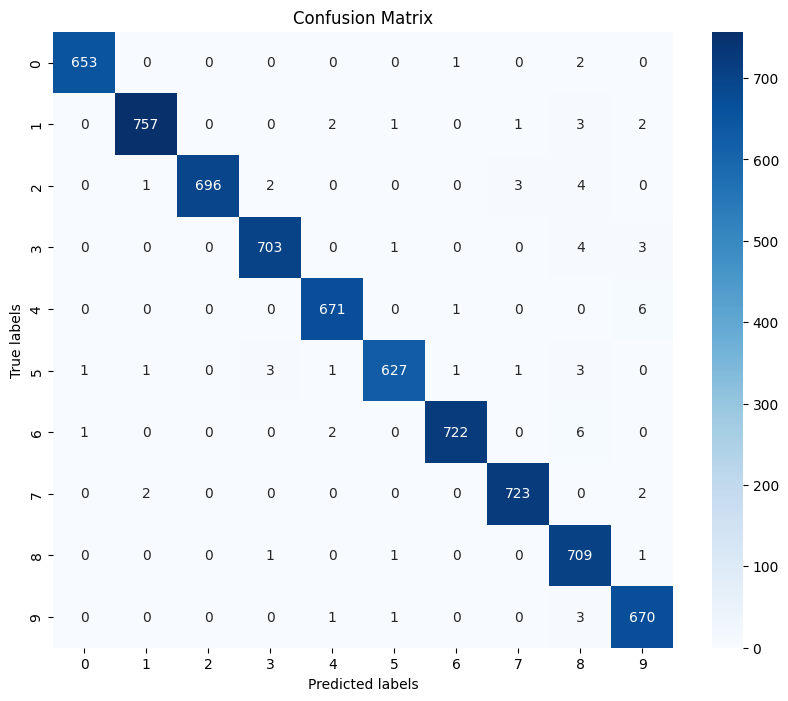

In [144]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on test data
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.35%
Probability of digit 2: 0.10%
Probability of digit 3: 1.39%
Probability of digit 4: 0.03%
Probability of digit 5: 1.05%
Probability of digit 6: 0.00%
Probability of digit 7: 96.68%
Probability of digit 8: 0.27%
Probability of digit 9: 0.12%


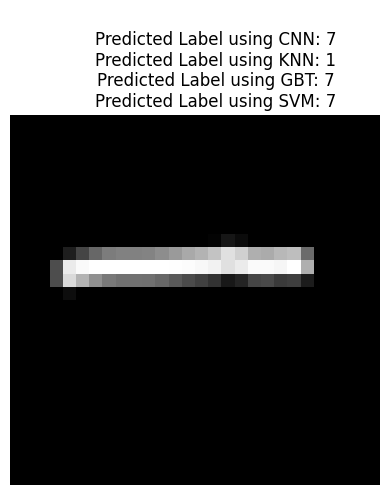

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.32%
Probability of digit 1: 93.14%
Probability of digit 2: 1.44%
Probability of digit 3: 0.33%
Probability of digit 4: 0.86%
Probability of digit 5: 0.28%
Probability of digit 6: 0.11%
Probability of digit 7: 2.10%
Probability of digit 8: 0.89%
Probability of digit 9: 0.54%


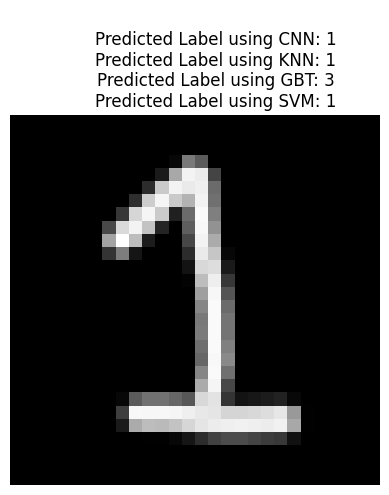

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.01%
Probability of digit 1: 98.77%
Probability of digit 2: 0.02%
Probability of digit 3: 0.00%
Probability of digit 4: 0.83%
Probability of digit 5: 0.07%
Probability of digit 6: 0.10%
Probability of digit 7: 0.09%
Probability of digit 8: 0.10%
Probability of digit 9: 0.01%


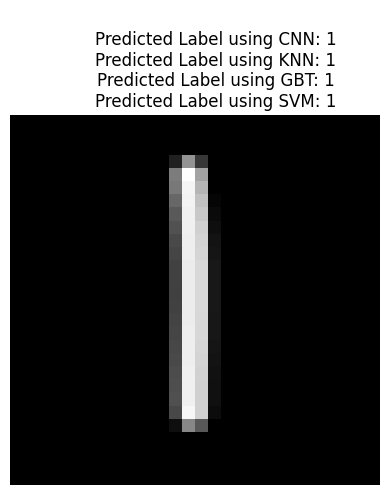

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.25%
Probability of digit 1: 5.04%
Probability of digit 2: 1.15%
Probability of digit 3: 0.20%
Probability of digit 4: 0.78%
Probability of digit 5: 57.56%
Probability of digit 6: 0.22%
Probability of digit 7: 17.08%
Probability of digit 8: 1.32%
Probability of digit 9: 16.41%


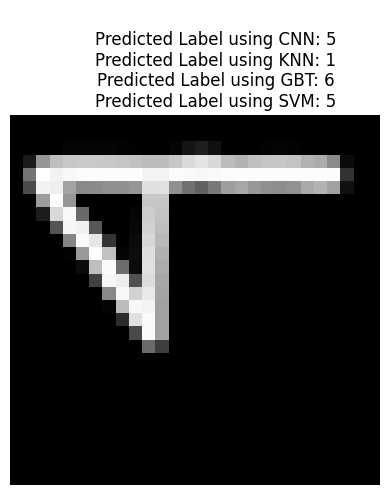

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.02%
Probability of digit 1: 3.58%
Probability of digit 2: 0.44%
Probability of digit 3: 0.10%
Probability of digit 4: 0.04%
Probability of digit 5: 0.02%
Probability of digit 6: 0.00%
Probability of digit 7: 95.64%
Probability of digit 8: 0.10%
Probability of digit 9: 0.06%


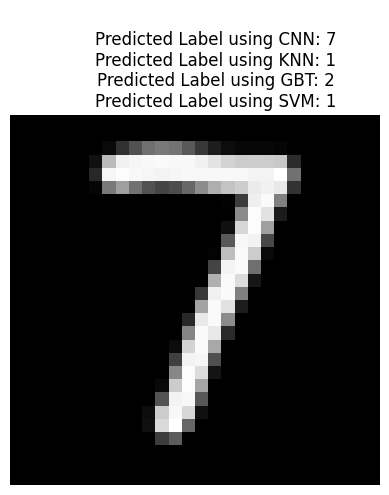

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.21%
Probability of digit 1: 0.63%
Probability of digit 2: 97.45%
Probability of digit 3: 0.83%
Probability of digit 4: 0.02%
Probability of digit 5: 0.01%
Probability of digit 6: 0.02%
Probability of digit 7: 0.64%
Probability of digit 8: 0.16%
Probability of digit 9: 0.02%


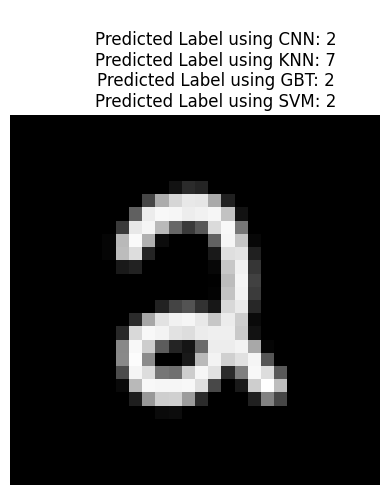

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.04%
Probability of digit 1: 0.09%
Probability of digit 2: 0.06%
Probability of digit 3: 0.42%
Probability of digit 4: 0.00%
Probability of digit 5: 98.90%
Probability of digit 6: 0.10%
Probability of digit 7: 0.07%
Probability of digit 8: 0.14%
Probability of digit 9: 0.17%


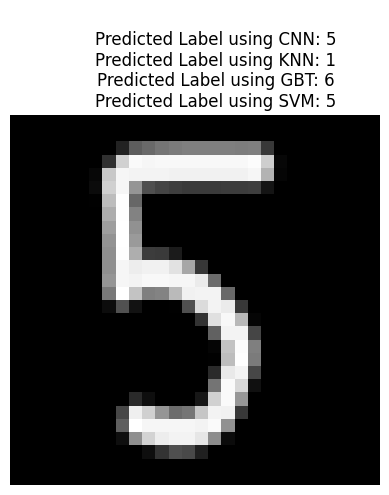

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.01%
Probability of digit 2: 0.01%
Probability of digit 3: 99.90%
Probability of digit 4: 0.00%
Probability of digit 5: 0.02%
Probability of digit 6: 0.00%
Probability of digit 7: 0.01%
Probability of digit 8: 0.01%
Probability of digit 9: 0.02%


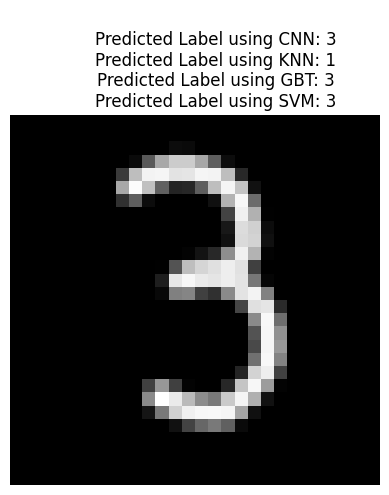

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.14%
Probability of digit 2: 0.01%
Probability of digit 3: 0.02%
Probability of digit 4: 14.26%
Probability of digit 5: 0.04%
Probability of digit 6: 0.00%
Probability of digit 7: 1.23%
Probability of digit 8: 0.19%
Probability of digit 9: 84.10%


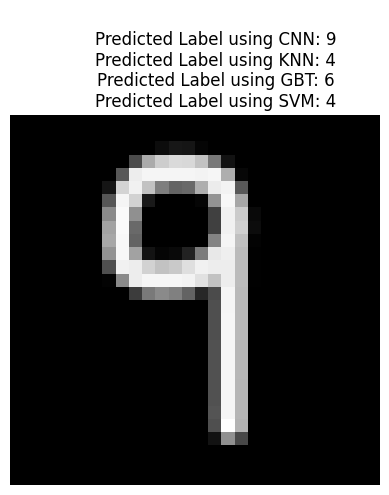

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.12%
Probability of digit 1: 0.87%
Probability of digit 2: 0.02%
Probability of digit 3: 0.39%
Probability of digit 4: 0.09%
Probability of digit 5: 89.58%
Probability of digit 6: 0.04%
Probability of digit 7: 5.19%
Probability of digit 8: 0.40%
Probability of digit 9: 3.29%


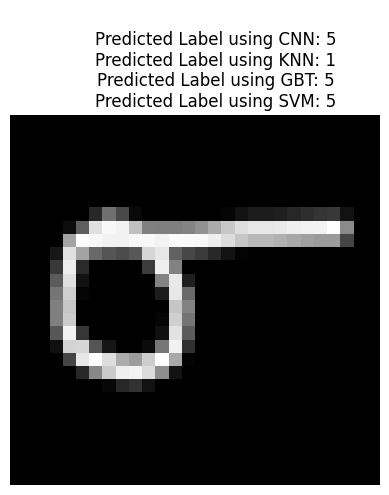

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.64%
Probability of digit 2: 0.86%
Probability of digit 3: 1.33%
Probability of digit 4: 1.99%
Probability of digit 5: 0.02%
Probability of digit 6: 0.00%
Probability of digit 7: 94.86%
Probability of digit 8: 0.17%
Probability of digit 9: 0.11%


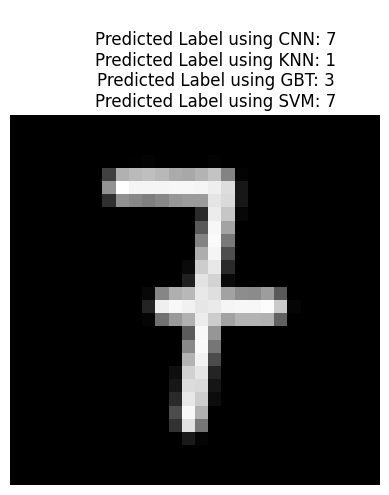

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.02%
Probability of digit 2: 0.01%
Probability of digit 3: 0.00%
Probability of digit 4: 99.83%
Probability of digit 5: 0.00%
Probability of digit 6: 0.00%
Probability of digit 7: 0.11%
Probability of digit 8: 0.00%
Probability of digit 9: 0.03%


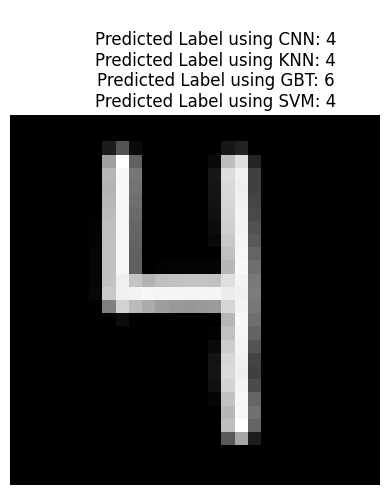

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.00%
Probability of digit 1: 0.09%
Probability of digit 2: 0.06%
Probability of digit 3: 0.01%
Probability of digit 4: 86.30%
Probability of digit 5: 0.03%
Probability of digit 6: 0.00%
Probability of digit 7: 1.57%
Probability of digit 8: 0.24%
Probability of digit 9: 11.69%


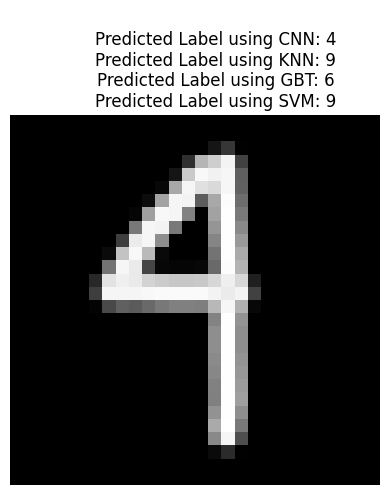

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 2.76%
Probability of digit 1: 1.63%
Probability of digit 2: 0.07%
Probability of digit 3: 0.16%
Probability of digit 4: 2.75%
Probability of digit 5: 12.37%
Probability of digit 6: 3.82%
Probability of digit 7: 0.15%
Probability of digit 8: 24.15%
Probability of digit 9: 52.14%


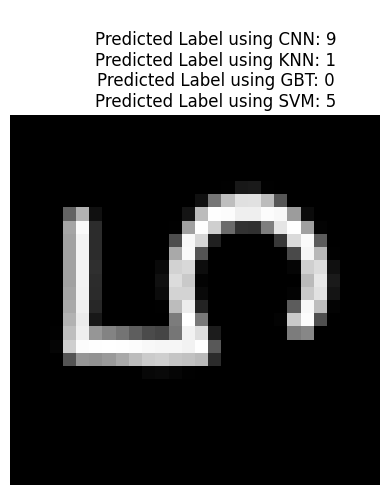

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Probability of digit 0: 0.04%
Probability of digit 1: 0.33%
Probability of digit 2: 99.38%
Probability of digit 3: 0.00%
Probability of digit 4: 0.00%
Probability of digit 5: 0.00%
Probability of digit 6: 0.00%
Probability of digit 7: 0.23%
Probability of digit 8: 0.01%
Probability of digit 9: 0.00%


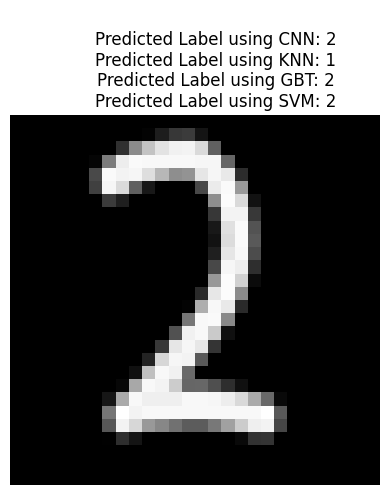

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Probability of digit 0: 0.03%
Probability of digit 1: 0.02%
Probability of digit 2: 0.05%
Probability of digit 3: 1.54%
Probability of digit 4: 0.09%
Probability of digit 5: 0.70%
Probability of digit 6: 0.12%
Probability of digit 7: 0.02%
Probability of digit 8: 97.27%
Probability of digit 9: 0.18%


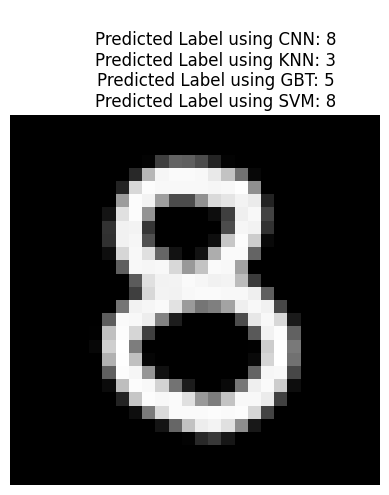

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Probability of digit 0: 0.88%
Probability of digit 1: 0.01%
Probability of digit 2: 0.02%
Probability of digit 3: 0.00%
Probability of digit 4: 0.01%
Probability of digit 5: 2.54%
Probability of digit 6: 96.43%
Probability of digit 7: 0.00%
Probability of digit 8: 0.07%
Probability of digit 9: 0.04%


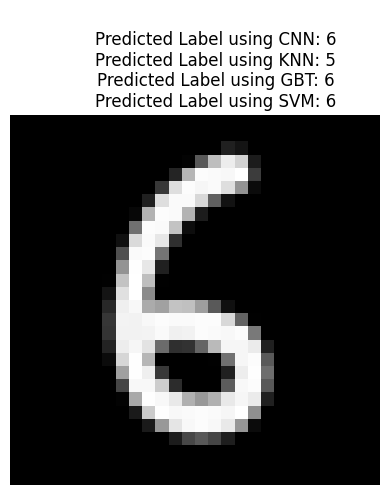

In [146]:
# convert an image I drew to test the model with

# Directory containing images
directory = "images/"

# Iterate through each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Load the handwritten image as grayscale
        image = Image.open(os.path.join(directory, filename)).convert("L")

        # Resize the image to 28x28 pixels
        image = image.resize((28, 28))

        # Invert the pixel values
        image = ImageOps.invert(image)

        # Convert the image to a numpy array
        image_array = np.array(image)

        # Flatten the image array
        image_flattened = image_array.flatten()

        # Scale the pixel values to the range [0, 1]
        # this is equivalent to using the MinMaxScaler()
        image_scaled = image_flattened / 255.0

        # Predict the label using the other trained models
        predicted_label_svm = svm_classifier.predict([image_scaled])[0]
        predicted_label_gbt = clf_gbt.predict([image_scaled])[0]
        predicted_label_knn = clf_knn.predict([image_scaled])[0]

        # Predict with CNN
        ni = image_scaled.reshape(-1, 28, 28, 1)
        logits = model.predict([ni])[0]
        predicted_label_cnn = np.argmax(logits) # make the prediction the index with highest value
        # Display the percentages 
        probs = np.exp(logits) / np.sum(np.exp(logits)) # Apply softmax function
        percentages = probs * 100 # Convert to percentages
        for i, percentage in enumerate(percentages):
            print(f"Probability of digit {i}: {percentage:.2f}%")

        # define an image that can be shown to compare to the prediction
        image_to_show = image_scaled.reshape(28, 28)

        # Display the image along with the predicted labels
        plt.imshow(image_to_show, cmap='gray')
        plt.axis('off')
        plt.title(f'\n\
        Predicted Label using CNN: {predicted_label_cnn}\n\
        Predicted Label using KNN: {predicted_label_knn}\n\
        Predicted Label using GBT: {predicted_label_gbt}\n\
        Predicted Label using SVM: {predicted_label_svm}')
        plt.show()
